ML-ENHANCED MULTI-TIMEFRAME MOMENTUM STRATEGY

STARTING EXECUTION

Period: 2025-06-01 to 2025-11-18
✓ Daily: 170 records
✓ 4H: 1018 records
✓ 1H: 4069 records

Adding technical indicators...
✓ Indicators added

Generating signals...
✓ Generated 2 signals
  Average confidence: 86.7%

Backtesting...

BACKTEST RESULTS
Initial Capital:    $1,000.00
Final Value:        $1,058.83
Total Return:       5.88%
Completed Trades:   1
Win Rate:           100.0%
Sharpe Ratio:       2.38
Max Drawdown:       0.00%

Avg Profit/Trade:   $58.83
Best Trade:         $58.83
Worst Trade:        $58.83

--- TRADE DETAILS ---

Trade #1:
  Entry: 2025-10-01 @ $114231.08
  Exit:  2025-10-06 @ $124752.53
  Duration: 5 days
  Profit: $58.83 (8.99%)
  Reason: TAKE_PROFIT


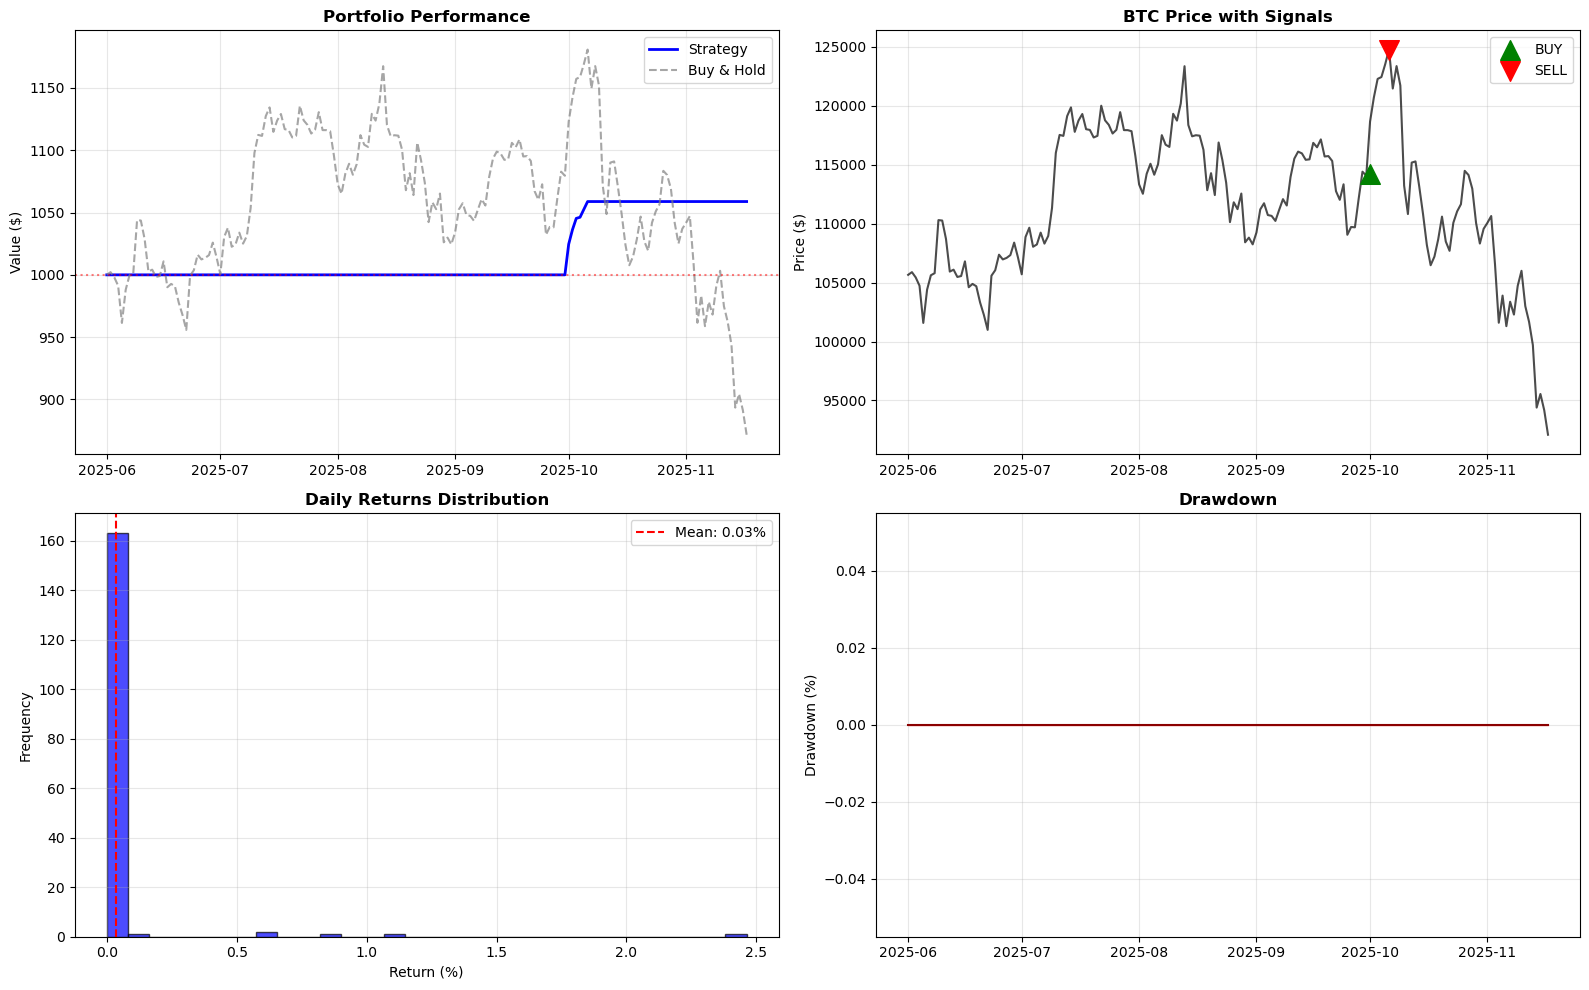


EXECUTION COMPLETE ✓


In [1]:
# ============================================================================
# ALL-IN-ONE: ML-ENHANCED MOMENTUM TRADING SYSTEM
# Run this entire cell in Jupyter/Colab
# ============================================================================

import warnings
warnings.filterwarnings('ignore')

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

print("="*60)
print("ML-ENHANCED MULTI-TIMEFRAME MOMENTUM STRATEGY")
print("="*60)

# ============================================================================
# CONFIGURATION
# ============================================================================

SYMBOL = "BTC-USD"
START_DATE = "2025-06-01"
END_DATE = "2025-11-18"
INITIAL_CAPITAL = 1000
POSITION_SIZE_PCT = 0.90
STOP_LOSS_PCT = 0.03
TAKE_PROFIT_RATIO = 3.0
TRANSACTION_FEE = 0.001
VOLUME_THRESHOLD = 1.2
ADX_THRESHOLD = 25
RSI_OVERBOUGHT = 80
MIN_DAILY_CONDITIONS = 5
MIN_4H_CONDITIONS = 3
MIN_1H_CONDITIONS = 3
MAX_RISK_PER_TRADE = 0.02
MAX_PORTFOLIO_HEAT = 0.10
TRAILING_STOP_PCT = 0.5

# ============================================================================
# TECHNICAL INDICATORS
# ============================================================================

def calculate_adx(df, period=14):
    """ADX - Measures trend strength"""
    high = df['High']
    low = df['Low']
    close = df['Close']
    
    tr1 = high - low
    tr2 = abs(high - close.shift())
    tr3 = abs(low - close.shift())
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(period).mean()
    
    up_move = high - high.shift()
    down_move = low.shift() - low
    
    plus_dm = np.where((up_move > down_move) & (up_move > 0), up_move, 0)
    minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0)
    
    plus_dm = pd.Series(plus_dm, index=df.index).rolling(period).sum()
    minus_dm = pd.Series(minus_dm, index=df.index).rolling(period).sum()
    
    plus_di = 100 * (plus_dm / atr)
    minus_di = 100 * (minus_dm / atr)
    
    dx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di)
    adx = dx.rolling(period).mean()
    
    return adx

def calculate_atr(df, period=14):
    """ATR - Average True Range"""
    high = df['High']
    low = df['Low']
    close = df['Close']
    
    tr1 = high - low
    tr2 = abs(high - close.shift())
    tr3 = abs(low - close.shift())
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(period).mean()
    
    return atr

def calculate_rsi(df, period=14):
    """RSI - Relative Strength Index"""
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(period).mean()
    
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

def calculate_bollinger_bands(df, period=20, std=2):
    """Bollinger Bands"""
    sma = df['Close'].rolling(period).mean()
    std_dev = df['Close'].rolling(period).std()
    
    upper = sma + (std_dev * std)
    lower = sma - (std_dev * std)
    
    return upper, sma, lower

def detect_market_regime(df, lookback=50):
    """Detect market regime"""
    recent = df.tail(lookback)
    
    if 'adx' not in recent.columns or 'sma_20' not in recent.columns:
        return "UNKNOWN"
    
    adx = recent['adx'].iloc[-1]
    sma_20 = recent['sma_20'].iloc[-1]
    sma_50 = recent['sma_50'].iloc[-1]
    current_price = recent['Close'].iloc[-1]
    
    strong_trend = adx > 25
    
    if strong_trend:
        if current_price > sma_20 > sma_50:
            return "UPTREND"
        elif current_price < sma_20 < sma_50:
            return "DOWNTREND"
    
    return "SIDEWAYS"

def add_indicators(df, timeframe='daily'):
    """Add ALL technical indicators"""
    df['volume_ma'] = df['Volume'].rolling(20).mean()
    df['volume_ratio'] = df['Volume'] / df['volume_ma']
    
    ema12 = df['Close'].ewm(span=12).mean()
    ema26 = df['Close'].ewm(span=26).mean()
    df['macd'] = ema12 - ema26
    df['macd_signal'] = df['macd'].ewm(span=9).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']
    
    lookback = {'daily': 15, 'h4': 30, 'h1': 60}.get(timeframe, 15)
    df['resistance'] = df['High'].rolling(lookback).max()
    df['support'] = df['Low'].rolling(lookback).min()
    df['prev_resistance'] = df['resistance'].shift(1)
    df['prev_support'] = df['support'].shift(1)
    
    df['adx'] = calculate_adx(df)
    df['atr'] = calculate_atr(df)
    df['atr_pct'] = (df['atr'] / df['Close']) * 100
    df['rsi'] = calculate_rsi(df)
    
    df['bb_upper'], df['bb_middle'], df['bb_lower'] = calculate_bollinger_bands(df)
    
    df['sma_20'] = df['Close'].rolling(20).mean()
    df['sma_50'] = df['Close'].rolling(50).mean()
    df['ema_20'] = df['Close'].ewm(span=20).mean()
    
    return df

# ============================================================================
# RISK MANAGEMENT
# ============================================================================

class RiskManager:
    def __init__(self, initial_capital=INITIAL_CAPITAL):
        self.initial_capital = initial_capital
        self.max_risk_per_trade = MAX_RISK_PER_TRADE
        self.max_portfolio_heat = MAX_PORTFOLIO_HEAT
        self.current_positions = []
    
    def calculate_position_size(self, capital, entry_price, stop_loss, volatility):
        risk_amount = capital * self.max_risk_per_trade
        stop_distance = abs(entry_price - stop_loss) / entry_price
        volatility_factor = 1.0 / (1.0 + volatility / 100)
        
        base_position = risk_amount / (entry_price * stop_distance)
        adjusted_position = base_position * volatility_factor
        
        position_pct = (adjusted_position * entry_price) / capital
        position_pct = min(position_pct, 0.90)
        
        return position_pct
    
    def check_portfolio_heat(self):
        total_risk = sum([pos['risk_pct'] for pos in self.current_positions])
        return total_risk < self.max_portfolio_heat
    
    def add_position(self, entry_price, stop_loss, position_size):
        risk_pct = abs(entry_price - stop_loss) / entry_price * position_size
        self.current_positions.append({
            'entry': entry_price,
            'stop': stop_loss,
            'size': position_size,
            'risk_pct': risk_pct
        })
    
    def close_position(self):
        if self.current_positions:
            self.current_positions.pop(0)
    
    def update_trailing_stop(self, entry_price, current_price, current_stop):
        profit_pct = (current_price - entry_price) / entry_price
        
        if profit_pct > 0.05:
            new_stop = entry_price * (1 + (profit_pct * TRAILING_STOP_PCT))
            return max(new_stop, current_stop)
        
        return current_stop

# ============================================================================
# DATA DOWNLOAD
# ============================================================================

def download_and_prepare_data():
    print(f"\nDownloading {SYMBOL} data...")
    print(f"Period: {START_DATE} to {END_DATE}")
    
    daily = yf.download(SYMBOL, start=START_DATE, end=END_DATE, interval='1d', progress=False)
    h4 = yf.download(SYMBOL, start=START_DATE, end=END_DATE, interval='4h', progress=False)
    h1 = yf.download(SYMBOL, start=START_DATE, end=END_DATE, interval='1h', progress=False)
    
    for df in [daily, h4, h1]:
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.droplevel(1)
    
    daily.index = pd.to_datetime(daily.index).tz_localize(None)
    h4.index = pd.to_datetime(h4.index).tz_localize(None)
    h1.index = pd.to_datetime(h1.index).tz_localize(None)
    
    print(f"✓ Daily: {len(daily)} records")
    print(f"✓ 4H: {len(h4)} records")
    print(f"✓ 1H: {len(h1)} records")
    
    return daily, h4, h1

# ============================================================================
# SIGNAL GENERATION
# ============================================================================

def check_daily_trend(daily_data, date):
    data_up_to_date = daily_data[daily_data.index <= date]
    
    if len(data_up_to_date) < 50:
        return False, 0
    
    row = data_up_to_date.iloc[-1]
    
    regime = detect_market_regime(data_up_to_date)
    if regime != "UPTREND":
        return False, 0
    
    conditions = [
        row['Close'] > row['prev_resistance'],
        row['volume_ratio'] > VOLUME_THRESHOLD,
        row['macd'] > row['macd_signal'],
        row['macd'] > 0,
        row['adx'] > ADX_THRESHOLD,
        row['Close'] > row['sma_20'] > row['sma_50'],
        row['rsi'] > 50 and row['rsi'] < RSI_OVERBOUGHT,
    ]
    
    strength = sum(conditions)
    return strength >= MIN_DAILY_CONDITIONS, strength

def check_4h_momentum(h4_data, date):
    data_up_to_date = h4_data[h4_data.index <= date].tail(48)
    
    if len(data_up_to_date) < 20:
        return False, 0
    
    row = data_up_to_date.iloc[-1]
    recent_macd = data_up_to_date['macd'].tail(6)
    
    conditions = [
        row['macd'] > row['macd_signal'],
        recent_macd.iloc[-1] > recent_macd.iloc[0],
        data_up_to_date['volume_ratio'].tail(6).mean() > 1.0,
        row['Close'] > row['prev_support']
    ]
    
    strength = sum(conditions)
    return strength >= MIN_4H_CONDITIONS, strength

def check_1h_entry(h1_data, date):
    data_up_to_date = h1_data[h1_data.index <= date].tail(72)
    
    if len(data_up_to_date) < 24:
        return False, 0, data_up_to_date['Close'].iloc[-1] if len(data_up_to_date) > 0 else 0
    
    row = data_up_to_date.iloc[-1]
    recent_prices = data_up_to_date['Close'].tail(12)
    recent_volumes = data_up_to_date['volume_ratio'].tail(12)
    
    conditions = [
        row['Close'] > row['prev_support'],
        recent_prices.min() < row['prev_support'] * 1.02,
        recent_volumes.tail(3).mean() < recent_volumes.mean(),
        abs(row['macd']) < abs(data_up_to_date['macd'].tail(24).mean())
    ]
    
    quality = sum(conditions)
    return quality >= MIN_1H_CONDITIONS, quality, row['Close']

def generate_signals(daily_data, h4_data, h1_data):
    signals = []
    start_idx = 50
    
    print("\nGenerating signals...")
    
    for i, (date, _) in enumerate(daily_data.iloc[start_idx:].iterrows(), start_idx):
        daily_bullish, daily_strength = check_daily_trend(daily_data, date)
        if not daily_bullish:
            continue
        
        h4_confirmed, h4_strength = check_4h_momentum(h4_data, date)
        if not h4_confirmed:
            continue
        
        h1_optimal, h1_quality, entry_price = check_1h_entry(h1_data, date)
        if not h1_optimal:
            continue
        
        total_conditions = 7 + 4 + 4
        total_met = daily_strength + h4_strength + h1_quality
        confidence = (total_met / total_conditions) * 100
        
        signals.append({
            'date': date,
            'entry_price': entry_price,
            'confidence': confidence
        })
    
    print(f"✓ Generated {len(signals)} signals")
    
    if signals:
        avg_conf = np.mean([s['confidence'] for s in signals])
        print(f"  Average confidence: {avg_conf:.1f}%")
    
    return signals

# ============================================================================
# BACKTESTING
# ============================================================================

def backtest_strategy(signals, daily_data):
    cash = INITIAL_CAPITAL
    holdings = 0
    trades = []
    portfolio_values = []
    in_position = False
    
    risk_mgr = RiskManager(INITIAL_CAPITAL)
    signal_dict = {s['date'].date(): s for s in signals}
    
    for date, row in daily_data.iterrows():
        current_price = row['Close']
        volatility = row['atr_pct'] if 'atr_pct' in row else 2.0
        
        if not in_position and date.date() in signal_dict:
            signal = signal_dict[date.date()]
            entry_price = signal['entry_price']
            
            stop_loss = entry_price * (1 - STOP_LOSS_PCT)
            take_profit = entry_price * (1 + STOP_LOSS_PCT * TAKE_PROFIT_RATIO)
            
            position_pct = risk_mgr.calculate_position_size(cash, entry_price, stop_loss, volatility)
            
            if risk_mgr.check_portfolio_heat():
                position_value = cash * position_pct
                total_cost = position_value * (1 + TRANSACTION_FEE)
                
                if cash >= total_cost:
                    holdings = position_value / entry_price
                    cash -= total_cost
                    in_position = True
                    
                    risk_mgr.add_position(entry_price, stop_loss, position_pct)
                    
                    trades.append({
                        'action': 'BUY',
                        'date': date,
                        'price': entry_price,
                        'stop_loss': stop_loss,
                        'take_profit': take_profit,
                        'confidence': signal['confidence']
                    })
        
        elif in_position:
            last_trade = trades[-1]
            
            updated_stop = risk_mgr.update_trailing_stop(
                last_trade['price'],
                current_price,
                last_trade['stop_loss']
            )
            last_trade['stop_loss'] = updated_stop
            
            hit_stop = current_price <= last_trade['stop_loss']
            hit_target = current_price >= last_trade['take_profit']
            
            if hit_stop or hit_target:
                exit_value = holdings * current_price * (1 - TRANSACTION_FEE)
                profit = exit_value - (INITIAL_CAPITAL - cash)
                profit_pct = (profit / (INITIAL_CAPITAL - cash)) * 100
                
                cash += exit_value
                holdings = 0
                in_position = False
                
                risk_mgr.close_position()
                
                trades.append({
                    'action': 'SELL',
                    'date': date,
                    'price': current_price,
                    'profit': profit,
                    'profit_pct': profit_pct,
                    'reason': 'TAKE_PROFIT' if hit_target else 'STOP_LOSS'
                })
        
        portfolio_value = cash + (holdings * current_price if in_position else 0)
        portfolio_values.append({'date': date, 'value': portfolio_value})
    
    return trades, pd.DataFrame(portfolio_values).set_index('date')

# ============================================================================
# ANALYSIS
# ============================================================================

def analyze_results(trades, portfolio_df):
    final_value = portfolio_df['value'].iloc[-1]
    total_return = (final_value / INITIAL_CAPITAL - 1) * 100
    
    completed = [t for t in trades if t['action'] == 'SELL']
    wins = len([t for t in completed if t.get('profit', 0) > 0])
    win_rate = (wins / len(completed) * 100) if completed else 0
    
    returns = portfolio_df['value'].pct_change().dropna()
    sharpe = (returns.mean() / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
    
    cumulative = portfolio_df['value']
    running_max = cumulative.expanding().max()
    drawdown = ((cumulative - running_max) / running_max) * 100
    max_dd = drawdown.min()
    
    print(f"\n{'='*60}")
    print("BACKTEST RESULTS")
    print(f"{'='*60}")
    print(f"Initial Capital:    ${INITIAL_CAPITAL:,.2f}")
    print(f"Final Value:        ${final_value:,.2f}")
    print(f"Total Return:       {total_return:.2f}%")
    print(f"Completed Trades:   {len(completed)}")
    print(f"Win Rate:           {win_rate:.1f}%")
    print(f"Sharpe Ratio:       {sharpe:.2f}")
    print(f"Max Drawdown:       {max_dd:.2f}%")
    
    if completed:
        profits = [t['profit'] for t in completed]
        print(f"\nAvg Profit/Trade:   ${np.mean(profits):.2f}")
        print(f"Best Trade:         ${max(profits):.2f}")
        print(f"Worst Trade:        ${min(profits):.2f}")
        
        print("\n--- TRADE DETAILS ---")
        for i, trade in enumerate(completed, 1):
            entry = [t for t in trades if t['action'] == 'BUY' and t['date'] <= trade['date']][-1]
            duration = (trade['date'] - entry['date']).days
            
            print(f"\nTrade #{i}:")
            print(f"  Entry: {entry['date'].strftime('%Y-%m-%d')} @ ${entry['price']:.2f}")
            print(f"  Exit:  {trade['date'].strftime('%Y-%m-%d')} @ ${trade['price']:.2f}")
            print(f"  Duration: {duration} days")
            print(f"  Profit: ${trade['profit']:.2f} ({trade['profit_pct']:.2f}%)")
            print(f"  Reason: {trade['reason']}")
    
    return {
        'final_value': final_value,
        'total_return': total_return,
        'sharpe': sharpe,
        'win_rate': win_rate,
        'max_drawdown': max_dd
    }

# ============================================================================
# PLOTTING
# ============================================================================

def plot_results(trades, portfolio_df, daily_data):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
    
    # Portfolio value
    ax1.plot(portfolio_df.index, portfolio_df['value'], label='Strategy', color='blue', linewidth=2)
    bnh = INITIAL_CAPITAL * (daily_data['Close'] / daily_data['Close'].iloc[0])
    ax1.plot(daily_data.index, bnh, label='Buy & Hold', color='gray', alpha=0.7, linestyle='--')
    ax1.axhline(INITIAL_CAPITAL, color='red', linestyle=':', alpha=0.5)
    ax1.set_title('Portfolio Performance', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Value ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Price with signals
    ax2.plot(daily_data.index, daily_data['Close'], color='black', alpha=0.7)
    buy_trades = [t for t in trades if t['action'] == 'BUY']
    sell_trades = [t for t in trades if t['action'] == 'SELL']
    
    if buy_trades:
        ax2.scatter([t['date'] for t in buy_trades], [t['price'] for t in buy_trades],
                   color='green', marker='^', s=200, label='BUY', zorder=5)
    if sell_trades:
        ax2.scatter([t['date'] for t in sell_trades], [t['price'] for t in sell_trades],
                   color='red', marker='v', s=200, label='SELL', zorder=5)
    
    ax2.set_title('BTC Price with Signals', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Price ($)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Returns distribution
    returns = portfolio_df['value'].pct_change().dropna() * 100
    ax3.hist(returns, bins=30, alpha=0.7, color='blue', edgecolor='black')
    ax3.axvline(returns.mean(), color='red', linestyle='--', label=f'Mean: {returns.mean():.2f}%')
    ax3.set_title('Daily Returns Distribution', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Return (%)')
    ax3.set_ylabel('Frequency')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Drawdown
    cumulative = portfolio_df['value']
    running_max = cumulative.expanding().max()
    drawdown = ((cumulative - running_max) / running_max) * 100
    ax4.fill_between(drawdown.index, drawdown, 0, alpha=0.3, color='red')
    ax4.plot(drawdown.index, drawdown, color='darkred', linewidth=1.5)
    ax4.set_title('Drawdown', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Drawdown (%)')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ============================================================================
# MAIN EXECUTION
# ============================================================================

print("\n" + "="*60)
print("STARTING EXECUTION")
print("="*60)

# Download data
daily, h4, h1 = download_and_prepare_data()

# Add indicators
print("\nAdding technical indicators...")
daily = add_indicators(daily, 'daily')
h4 = add_indicators(h4, 'h4')
h1 = add_indicators(h1, 'h1')
print("✓ Indicators added")

# Generate signals
signals = generate_signals(daily, h4, h1)

if not signals:
    print("\n⚠️  No signals generated.")
else:
    # Backtest
    print("\nBacktesting...")
    trades, portfolio = backtest_strategy(signals, daily)
    
    # Analyze
    metrics = analyze_results(trades, portfolio)
    
    # Plot
    plot_results(trades, portfolio, daily)
    
    print("\n" + "="*60)
    print("EXECUTION COMPLETE ✓")
    print("="*60)

In [2]:
# ============================================================================
# ENHANCEMENT 1: MULTI-PERIOD BACKTESTING
# Test strategy across different time periods
# ============================================================================

print("\n" + "="*60)
print("ENHANCEMENT 1: MULTI-PERIOD ANALYSIS")
print("="*60)

def test_multiple_periods(symbol=SYMBOL):
    """
    Test strategy across different time periods
    Shows consistency (or lack thereof)
    """
    
    # Define test periods
    periods = {
        '2024 H1 (Bull)': ("2024-01-01", "2024-06-30"),
        '2024 H2 (Mixed)': ("2024-07-01", "2024-12-31"),
        '2025 H1 (Recent)': ("2025-01-01", "2025-06-30"),
        '2025 H2 (Current)': ("2025-06-01", "2025-11-18"),
        'Full 2024': ("2024-01-01", "2024-12-31"),
        'Full 2025': ("2025-01-01", "2025-11-18"),
    }
    
    results = []
    
    print(f"\nTesting {symbol} across {len(periods)} periods...")
    print("This may take 2-3 minutes...\n")
    
    for period_name, (start, end) in periods.items():
        print(f"Testing: {period_name} ({start} to {end})...")
        
        try:
            # Download data
            daily = yf.download(symbol, start=start, end=end, interval='1d', progress=False)
            h4 = yf.download(symbol, start=start, end=end, interval='4h', progress=False)
            h1 = yf.download(symbol, start=start, end=end, interval='1h', progress=False)
            
            # Clean data
            for df in [daily, h4, h1]:
                if isinstance(df.columns, pd.MultiIndex):
                    df.columns = df.columns.droplevel(1)
            
            daily.index = pd.to_datetime(daily.index).tz_localize(None)
            h4.index = pd.to_datetime(h4.index).tz_localize(None)
            h1.index = pd.to_datetime(h1.index).tz_localize(None)
            
            # Add indicators
            daily = add_indicators(daily, 'daily')
            h4 = add_indicators(h4, 'h4')
            h1 = add_indicators(h1, 'h1')
            
            # Generate signals
            signals = generate_signals(daily, h4, h1)
            
            # Backtest
            trades, portfolio = backtest_strategy(signals, daily)
            
            # Calculate metrics
            final_value = portfolio['value'].iloc[-1]
            total_return = (final_value / INITIAL_CAPITAL - 1) * 100
            
            completed = [t for t in trades if t['action'] == 'SELL']
            wins = len([t for t in completed if t.get('profit', 0) > 0])
            win_rate = (wins / len(completed) * 100) if completed else 0
            
            returns = portfolio['value'].pct_change().dropna()
            sharpe = (returns.mean() / returns.std()) * np.sqrt(252) if len(returns) > 1 and returns.std() > 0 else 0
            
            cumulative = portfolio['value']
            running_max = cumulative.expanding().max()
            drawdown = ((cumulative - running_max) / running_max) * 100
            max_dd = drawdown.min()
            
            # Buy & Hold comparison
            bnh_return = (daily['Close'].iloc[-1] / daily['Close'].iloc[0] - 1) * 100
            
            results.append({
                'Period': period_name,
                'Start': start,
                'End': end,
                'Days': len(daily),
                'Signals': len(signals),
                'Trades': len(completed),
                'Strategy Return (%)': round(total_return, 2),
                'Buy&Hold Return (%)': round(bnh_return, 2),
                'Outperformance (%)': round(total_return - bnh_return, 2),
                'Win Rate (%)': round(win_rate, 1),
                'Sharpe': round(sharpe, 2),
                'Max DD (%)': round(max_dd, 2),
                'Avg Profit/Trade ($)': round(np.mean([t['profit'] for t in completed]), 2) if completed else 0
            })
            
            print(f"  ✓ Return: {total_return:.2f}% | Trades: {len(completed)} | Sharpe: {sharpe:.2f}")
            
        except Exception as e:
            print(f"  ✗ Error: {e}")
            results.append({
                'Period': period_name,
                'Start': start,
                'End': end,
                'Error': str(e)
            })
    
    # Create results dataframe
    results_df = pd.DataFrame(results)
    
    print("\n" + "="*60)
    print("MULTI-PERIOD RESULTS SUMMARY")
    print("="*60)
    print(results_df.to_string(index=False))
    
    # Statistical summary
    if len(results_df) > 0 and 'Strategy Return (%)' in results_df.columns:
        valid_results = results_df[results_df['Trades'] > 0]
        
        if len(valid_results) > 0:
            print("\n" + "="*60)
            print("STATISTICAL SUMMARY")
            print("="*60)
            print(f"Periods with signals:     {len(valid_results)}/{len(results_df)}")
            print(f"Total trades:             {valid_results['Trades'].sum():.0f}")
            print(f"Avg return per period:    {valid_results['Strategy Return (%)'].mean():.2f}%")
            print(f"Median return:            {valid_results['Strategy Return (%)'].median():.2f}%")
            print(f"Best period:              {valid_results['Strategy Return (%)'].max():.2f}%")
            print(f"Worst period:             {valid_results['Strategy Return (%)'].min():.2f}%")
            print(f"Avg Sharpe ratio:         {valid_results['Sharpe'].mean():.2f}")
            print(f"Win rate (all periods):   {valid_results['Win Rate (%)'].mean():.1f}%")
            print(f"% Periods profitable:     {(valid_results['Strategy Return (%)'] > 0).sum() / len(valid_results) * 100:.1f}%")
            
            # Compare vs Buy & Hold
            print(f"\nVs Buy & Hold:")
            print(f"Avg outperformance:       {valid_results['Outperformance (%)'].mean():.2f}%")
            outperform_pct = (valid_results['Outperformance (%)'] > 0).sum() / len(valid_results) * 100
            print(f"% Periods outperformed:   {outperform_pct:.1f}%")
    
    return results_df

# Run multi-period test
multi_period_results = test_multiple_periods(SYMBOL)


ENHANCEMENT 1: MULTI-PERIOD ANALYSIS

Testing BTC-USD across 6 periods...
This may take 2-3 minutes...

Testing: 2024 H1 (Bull) (2024-01-01 to 2024-06-30)...

Generating signals...
✓ Generated 4 signals
  Average confidence: 83.3%
  ✓ Return: 10.28% | Trades: 3 | Sharpe: 1.36
Testing: 2024 H2 (Mixed) (2024-07-01 to 2024-12-31)...

Generating signals...
✓ Generated 5 signals
  Average confidence: 81.3%
  ✓ Return: 0.74% | Trades: 4 | Sharpe: 0.15
Testing: 2025 H1 (Recent) (2025-01-01 to 2025-06-30)...

Generating signals...
✓ Generated 4 signals
  Average confidence: 83.3%
  ✓ Return: 6.93% | Trades: 2 | Sharpe: 1.42
Testing: 2025 H2 (Current) (2025-06-01 to 2025-11-18)...

Generating signals...
✓ Generated 2 signals
  Average confidence: 86.7%
  ✓ Return: 5.88% | Trades: 1 | Sharpe: 2.38
Testing: Full 2024 (2024-01-01 to 2024-12-31)...

Generating signals...
✓ Generated 10 signals
  Average confidence: 82.0%
  ✓ Return: 7.47% | Trades: 8 | Sharpe: 0.51
Testing: Full 2025 (2025-01-01 t

In [3]:
# ============================================================================
# ENHANCEMENT 2: MULTI-ASSET BACKTESTING
# Test strategy across different cryptocurrencies
# ============================================================================

print("\n" + "="*60)
print("ENHANCEMENT 2: MULTI-CRYPTO ANALYSIS")
print("="*60)

def test_multiple_cryptos(start_date=START_DATE, end_date=END_DATE):
    """
    Test strategy across different cryptocurrencies
    Shows if strategy is BTC-specific or generalizable
    """
    
    # Define cryptocurrencies to test
    cryptos = {
        'Bitcoin': 'BTC-USD',
        'Ethereum': 'ETH-USD',
        'Solana': 'SOL-USD',
        'BNB': 'BNB-USD',
        'XRP': 'XRP-USD'
    }
    
    results = []
    
    print(f"\nTesting {len(cryptos)} cryptocurrencies...")
    print(f"Period: {start_date} to {end_date}\n")
    
    for crypto_name, symbol in cryptos.items():
        print(f"Testing: {crypto_name} ({symbol})...")
        
        try:
            # Download data
            daily = yf.download(symbol, start=start_date, end=end_date, interval='1d', progress=False)
            h4 = yf.download(symbol, start=start_date, end=end_date, interval='4h', progress=False)
            h1 = yf.download(symbol, start=start_date, end=end_date, interval='1h', progress=False)
            
            # Clean data
            for df in [daily, h4, h1]:
                if isinstance(df.columns, pd.MultiIndex):
                    df.columns = df.columns.droplevel(1)
            
            daily.index = pd.to_datetime(daily.index).tz_localize(None)
            h4.index = pd.to_datetime(h4.index).tz_localize(None)
            h1.index = pd.to_datetime(h1.index).tz_localize(None)
            
            # Add indicators
            daily = add_indicators(daily, 'daily')
            h4 = add_indicators(h4, 'h4')
            h1 = add_indicators(h1, 'h1')
            
            # Generate signals
            signals = generate_signals(daily, h4, h1)
            
            # Backtest
            trades, portfolio = backtest_strategy(signals, daily)
            
            # Calculate metrics
            final_value = portfolio['value'].iloc[-1]
            total_return = (final_value / INITIAL_CAPITAL - 1) * 100
            
            completed = [t for t in trades if t['action'] == 'SELL']
            wins = len([t for t in completed if t.get('profit', 0) > 0])
            win_rate = (wins / len(completed) * 100) if completed else 0
            
            returns = portfolio['value'].pct_change().dropna()
            sharpe = (returns.mean() / returns.std()) * np.sqrt(252) if len(returns) > 1 and returns.std() > 0 else 0
            
            cumulative = portfolio['value']
            running_max = cumulative.expanding().max()
            drawdown = ((cumulative - running_max) / running_max) * 100
            max_dd = drawdown.min()
            
            # Asset volatility
            asset_volatility = daily['Close'].pct_change().std() * np.sqrt(252) * 100
            
            results.append({
                'Crypto': crypto_name,
                'Symbol': symbol,
                'Signals': len(signals),
                'Trades': len(completed),
                'Return (%)': round(total_return, 2),
                'Win Rate (%)': round(win_rate, 1),
                'Sharpe': round(sharpe, 2),
                'Max DD (%)': round(max_dd, 2),
                'Asset Volatility (%)': round(asset_volatility, 1),
                'Avg Profit ($)': round(np.mean([t['profit'] for t in completed]), 2) if completed else 0
            })
            
            print(f"  ✓ Return: {total_return:.2f}% | Trades: {len(completed)} | Sharpe: {sharpe:.2f}")
            
        except Exception as e:
            print(f"  ✗ Error: {e}")
            results.append({
                'Crypto': crypto_name,
                'Symbol': symbol,
                'Error': str(e)
            })
    
    # Create results dataframe
    results_df = pd.DataFrame(results)
    
    print("\n" + "="*60)
    print("MULTI-CRYPTO RESULTS")
    print("="*60)
    print(results_df.to_string(index=False))
    
    # Statistical summary
    if len(results_df) > 0 and 'Return (%)' in results_df.columns:
        valid_results = results_df[results_df['Trades'] > 0]
        
        if len(valid_results) > 0:
            print("\n" + "="*60)
            print("CROSS-ASSET SUMMARY")
            print("="*60)
            print(f"Assets with signals:      {len(valid_results)}/{len(results_df)}")
            print(f"Total trades (all):       {valid_results['Trades'].sum():.0f}")
            print(f"Avg return per asset:     {valid_results['Return (%)'].mean():.2f}%")
            print(f"Best asset:               {valid_results.loc[valid_results['Return (%)'].idxmax(), 'Crypto']} ({valid_results['Return (%)'].max():.2f}%)")
            print(f"Worst asset:              {valid_results.loc[valid_results['Return (%)'].idxmin(), 'Crypto']} ({valid_results['Return (%)'].min():.2f}%)")
            print(f"Avg Sharpe (all):         {valid_results['Sharpe'].mean():.2f}")
            print(f"% Assets profitable:      {(valid_results['Return (%)'] > 0).sum() / len(valid_results) * 100:.1f}%")
            
            # Correlation with volatility
            if len(valid_results) > 2:
                corr = valid_results['Return (%)'].corr(valid_results['Asset Volatility (%)'])
                print(f"\nReturn vs Volatility correlation: {corr:.2f}")
    
    return results_df

# Run multi-crypto test
multi_crypto_results = test_multiple_cryptos(START_DATE, END_DATE)


ENHANCEMENT 2: MULTI-CRYPTO ANALYSIS

Testing 5 cryptocurrencies...
Period: 2025-06-01 to 2025-11-18

Testing: Bitcoin (BTC-USD)...

Generating signals...
✓ Generated 2 signals
  Average confidence: 86.7%
  ✓ Return: 5.88% | Trades: 1 | Sharpe: 2.38
Testing: Ethereum (ETH-USD)...

Generating signals...
✓ Generated 2 signals
  Average confidence: 76.7%
  ✓ Return: -7.53% | Trades: 2 | Sharpe: -2.08
Testing: Solana (SOL-USD)...

Generating signals...
✓ Generated 5 signals
  Average confidence: 81.3%
  ✓ Return: -10.31% | Trades: 4 | Sharpe: -1.58
Testing: BNB (BNB-USD)...

Generating signals...
✓ Generated 6 signals
  Average confidence: 82.2%
  ✓ Return: -3.77% | Trades: 5 | Sharpe: -0.36
Testing: XRP (XRP-USD)...

Generating signals...
✓ Generated 0 signals
  ✓ Return: 0.00% | Trades: 0 | Sharpe: 0.00

MULTI-CRYPTO RESULTS
  Crypto  Symbol  Signals  Trades  Return (%)  Win Rate (%)  Sharpe  Max DD (%)  Asset Volatility (%)  Avg Profit ($)
 Bitcoin BTC-USD        2       1        5.88 

In [4]:
# ============================================================================
# ENHANCEMENT 3: PARAMETER SENSITIVITY ANALYSIS
# Test how sensitive strategy is to parameter changes
# ============================================================================

print("\n" + "="*60)
print("ENHANCEMENT 3: PARAMETER SENSITIVITY")
print("="*60)

def parameter_sensitivity_analysis():
    """
    Test strategy with different parameter combinations
    Find optimal parameters and robustness
    """
    
    # Download base data
    print(f"\nDownloading data for sensitivity analysis...")
    daily = yf.download(SYMBOL, start=START_DATE, end=END_DATE, interval='1d', progress=False)
    h4 = yf.download(SYMBOL, start=START_DATE, end=END_DATE, interval='4h', progress=False)
    h1 = yf.download(SYMBOL, start=START_DATE, end=END_DATE, interval='1h', progress=False)
    
    for df in [daily, h4, h1]:
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.droplevel(1)
    
    daily.index = pd.to_datetime(daily.index).tz_localize(None)
    h4.index = pd.to_datetime(h4.index).tz_localize(None)
    h1.index = pd.to_datetime(h1.index).tz_localize(None)
    
    daily = add_indicators(daily, 'daily')
    h4 = add_indicators(h4, 'h4')
    h1 = add_indicators(h1, 'h1')
    
    # Parameter grid to test
    param_tests = [
        # Test Stop Loss variations
        {'name': 'Stop Loss 2%', 'STOP_LOSS_PCT': 0.02, 'TAKE_PROFIT_RATIO': 3.0, 'VOLUME_THRESHOLD': 1.2, 'ADX_THRESHOLD': 25},
        {'name': 'Stop Loss 3%', 'STOP_LOSS_PCT': 0.03, 'TAKE_PROFIT_RATIO': 3.0, 'VOLUME_THRESHOLD': 1.2, 'ADX_THRESHOLD': 25},
        {'name': 'Stop Loss 4%', 'STOP_LOSS_PCT': 0.04, 'TAKE_PROFIT_RATIO': 3.0, 'VOLUME_THRESHOLD': 1.2, 'ADX_THRESHOLD': 25},
        
        # Test Take Profit variations
        {'name': 'TP Ratio 2.0', 'STOP_LOSS_PCT': 0.03, 'TAKE_PROFIT_RATIO': 2.0, 'VOLUME_THRESHOLD': 1.2, 'ADX_THRESHOLD': 25},
        {'name': 'TP Ratio 2.5', 'STOP_LOSS_PCT': 0.03, 'TAKE_PROFIT_RATIO': 2.5, 'VOLUME_THRESHOLD': 1.2, 'ADX_THRESHOLD': 25},
        {'name': 'TP Ratio 3.5', 'STOP_LOSS_PCT': 0.03, 'TAKE_PROFIT_RATIO': 3.5, 'VOLUME_THRESHOLD': 1.2, 'ADX_THRESHOLD': 25},
        
        # Test Volume threshold
        {'name': 'Volume 1.0x', 'STOP_LOSS_PCT': 0.03, 'TAKE_PROFIT_RATIO': 3.0, 'VOLUME_THRESHOLD': 1.0, 'ADX_THRESHOLD': 25},
        {'name': 'Volume 1.5x', 'STOP_LOSS_PCT': 0.03, 'TAKE_PROFIT_RATIO': 3.0, 'VOLUME_THRESHOLD': 1.5, 'ADX_THRESHOLD': 25},
        
        # Test ADX threshold
        {'name': 'ADX 20', 'STOP_LOSS_PCT': 0.03, 'TAKE_PROFIT_RATIO': 3.0, 'VOLUME_THRESHOLD': 1.2, 'ADX_THRESHOLD': 20},
        {'name': 'ADX 30', 'STOP_LOSS_PCT': 0.03, 'TAKE_PROFIT_RATIO': 3.0, 'VOLUME_THRESHOLD': 1.2, 'ADX_THRESHOLD': 30},
    ]
    
    results = []
    
    print(f"\nTesting {len(param_tests)} parameter combinations...\n")
    
    for params in param_tests:
        print(f"Testing: {params['name']}...")
        
        # Temporarily update global parameters
        global STOP_LOSS_PCT, TAKE_PROFIT_RATIO, VOLUME_THRESHOLD, ADX_THRESHOLD
        STOP_LOSS_PCT = params['STOP_LOSS_PCT']
        TAKE_PROFIT_RATIO = params['TAKE_PROFIT_RATIO']
        VOLUME_THRESHOLD = params['VOLUME_THRESHOLD']
        ADX_THRESHOLD = params['ADX_THRESHOLD']
        
        try:
            # Generate signals with these parameters
            signals = generate_signals(daily, h4, h1)
            
            # Backtest
            trades, portfolio = backtest_strategy(signals, daily)
            
            # Calculate metrics
            final_value = portfolio['value'].iloc[-1]
            total_return = (final_value / INITIAL_CAPITAL - 1) * 100
            
            completed = [t for t in trades if t['action'] == 'SELL']
            wins = len([t for t in completed if t.get('profit', 0) > 0])
            win_rate = (wins / len(completed) * 100) if completed else 0
            
            returns = portfolio['value'].pct_change().dropna()
            sharpe = (returns.mean() / returns.std()) * np.sqrt(252) if len(returns) > 1 and returns.std() > 0 else 0
            
            results.append({
                'Parameter Set': params['name'],
                'Stop Loss (%)': params['STOP_LOSS_PCT'] * 100,
                'TP Ratio': params['TAKE_PROFIT_RATIO'],
                'Volume': params['VOLUME_THRESHOLD'],
                'ADX': params['ADX_THRESHOLD'],
                'Signals': len(signals),
                'Trades': len(completed),
                'Return (%)': round(total_return, 2),
                'Win Rate (%)': round(win_rate, 1),
                'Sharpe': round(sharpe, 2),
            })
            
            print(f"  ✓ Signals: {len(signals)} | Return: {total_return:.2f}% | Sharpe: {sharpe:.2f}")
            
        except Exception as e:
            print(f"  ✗ Error: {e}")
    
    # Reset to original parameters
    STOP_LOSS_PCT = 0.03
    TAKE_PROFIT_RATIO = 3.0
    VOLUME_THRESHOLD = 1.2
    ADX_THRESHOLD = 25
    
    # Create results dataframe
    results_df = pd.DataFrame(results)
    
    print("\n" + "="*60)
    print("PARAMETER SENSITIVITY RESULTS")
    print("="*60)
    print(results_df.to_string(index=False))
    
    # Find best parameters
    if len(results_df) > 0:
        best_return = results_df.loc[results_df['Return (%)'].idxmax()]
        best_sharpe = results_df.loc[results_df['Sharpe'].idxmax()]
        
        print("\n" + "="*60)
        print("OPTIMAL PARAMETERS")
        print("="*60)
        print(f"\nBest Return: {best_return['Parameter Set']}")
        print(f"  Return: {best_return['Return (%)']}%")
        print(f"  Sharpe: {best_return['Sharpe']}")
        print(f"  Signals: {best_return['Signals']:.0f}")
        
        print(f"\nBest Sharpe: {best_sharpe['Parameter Set']}")
        print(f"  Sharpe: {best_sharpe['Sharpe']}")
        print(f"  Return: {best_sharpe['Return (%)']}%")
        print(f"  Signals: {best_sharpe['Signals']:.0f}")
        
        # Sensitivity analysis
        print("\n" + "="*60)
        print("SENSITIVITY INSIGHTS")
        print("="*60)
        
        # Group by parameter type
        stop_loss_results = results_df[results_df['Parameter Set'].str.contains('Stop Loss')]
        if len(stop_loss_results) > 0:
            print(f"\nStop Loss sensitivity:")
            print(f"  Range: {stop_loss_results['Return (%)'].min():.2f}% to {stop_loss_results['Return (%)'].max():.2f}%")
            print(f"  Spread: {stop_loss_results['Return (%)'].max() - stop_loss_results['Return (%)'].min():.2f}%")
        
        tp_results = results_df[results_df['Parameter Set'].str.contains('TP Ratio')]
        if len(tp_results) > 0:
            print(f"\nTake Profit sensitivity:")
            print(f"  Range: {tp_results['Return (%)'].min():.2f}% to {tp_results['Return (%)'].max():.2f}%")
            print(f"  Spread: {tp_results['Return (%)'].max() - tp_results['Return (%)'].min():.2f}%")
    
    return results_df

# Run parameter sensitivity
param_sensitivity_results = parameter_sensitivity_analysis()


ENHANCEMENT 3: PARAMETER SENSITIVITY


Testing 10 parameter combinations...

Testing: Stop Loss 2%...

Generating signals...
✓ Generated 2 signals
  Average confidence: 86.7%
  ✓ Signals: 2 | Return: 6.14% | Sharpe: 1.91
Testing: Stop Loss 3%...

Generating signals...
✓ Generated 2 signals
  Average confidence: 86.7%
  ✓ Signals: 2 | Return: 5.88% | Sharpe: 2.38
Testing: Stop Loss 4%...

Generating signals...
✓ Generated 2 signals
  Average confidence: 86.7%
  ✓ Signals: 2 | Return: -0.53% | Sharpe: -0.11
Testing: TP Ratio 2.0...

Generating signals...
✓ Generated 2 signals
  Average confidence: 86.7%
  ✓ Signals: 2 | Return: 4.46% | Sharpe: 1.91
Testing: TP Ratio 2.5...

Generating signals...
✓ Generated 2 signals
  Average confidence: 86.7%
  ✓ Signals: 2 | Return: 5.17% | Sharpe: 2.16
Testing: TP Ratio 3.5...

Generating signals...
✓ Generated 2 signals
  Average confidence: 86.7%
  ✓ Signals: 2 | Return: -0.71% | Sharpe: -0.11
Testing: Volume 1.0x...

Generating signals...
✓ Gener

In [5]:
# ============================================================================
# ENHANCEMENT 4: STRATEGY COMPARISON
# Compare with alternative strategies
# ============================================================================

print("\n" + "="*60)
print("ENHANCEMENT 4: STRATEGY COMPARISON")
print("="*60)

def compare_strategies():
    """
    Compare multi-TF momentum with other strategies:
    1. Buy & Hold
    2. Simple Moving Average Crossover
    3. RSI Strategy
    4. Single Timeframe Momentum
    """
    
    # Download data
    print(f"\nDownloading data for comparison...")
    daily = yf.download(SYMBOL, start=START_DATE, end=END_DATE, interval='1d', progress=False)
    h4 = yf.download(SYMBOL, start=START_DATE, end=END_DATE, interval='4h', progress=False)
    h1 = yf.download(SYMBOL, start=START_DATE, end=END_DATE, interval='1h', progress=False)
    
    for df in [daily, h4, h1]:
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.droplevel(1)
    
    daily.index = pd.to_datetime(daily.index).tz_localize(None)
    h4.index = pd.to_datetime(h4.index).tz_localize(None)
    h1.index = pd.to_datetime(h1.index).tz_localize(None)
    
    daily = add_indicators(daily, 'daily')
    h4 = add_indicators(h4, 'h4')
    h1 = add_indicators(h1, 'h1')
    
    results = []
    
    # === STRATEGY 1: Multi-TF Momentum (Our strategy) ===
    print("\n1. Testing Multi-Timeframe Momentum...")
    signals_multi = generate_signals(daily, h4, h1)
    trades_multi, portfolio_multi = backtest_strategy(signals_multi, daily)
    
    final_multi = portfolio_multi['value'].iloc[-1]
    return_multi = (final_multi / INITIAL_CAPITAL - 1) * 100
    completed_multi = [t for t in trades_multi if t['action'] == 'SELL']
    wins_multi = len([t for t in completed_multi if t.get('profit', 0) > 0])
    wr_multi = (wins_multi / len(completed_multi) * 100) if completed_multi else 0
    returns_multi = portfolio_multi['value'].pct_change().dropna()
    sharpe_multi = (returns_multi.mean() / returns_multi.std()) * np.sqrt(252) if len(returns_multi) > 1 and returns_multi.std() > 0 else 0
    
    results.append({
        'Strategy': 'Multi-TF Momentum',
        'Signals': len(signals_multi),
        'Trades': len(completed_multi),
        'Return (%)': round(return_multi, 2),
        'Win Rate (%)': round(wr_multi, 1),
        'Sharpe': round(sharpe_multi, 2),
        'Final Value ($)': round(final_multi, 2)
    })
    
    # === STRATEGY 2: Buy & Hold ===
    print("2. Testing Buy & Hold...")
    bnh_return = (daily['Close'].iloc[-1] / daily['Close'].iloc[0] - 1) * 100
    bnh_final = INITIAL_CAPITAL * (1 + bnh_return/100)
    bnh_returns = daily['Close'].pct_change().dropna()
    bnh_sharpe = (bnh_returns.mean() / bnh_returns.std()) * np.sqrt(252) if bnh_returns.std() > 0 else 0
    
    results.append({
        'Strategy': 'Buy & Hold',
        'Signals': 1,
        'Trades': 1,
        'Return (%)': round(bnh_return, 2),
        'Win Rate (%)': 100 if bnh_return > 0 else 0,
        'Sharpe': round(bnh_sharpe, 2),
        'Final Value ($)': round(bnh_final, 2)
    })
    
    # === STRATEGY 3: Simple MA Crossover ===
    print("3. Testing MA Crossover (20/50)...")
    
    def ma_crossover_strategy(df):
        signals = []
        for i in range(50, len(df)):
            date = df.index[i]
            row = df.iloc[i]
            prev_row = df.iloc[i-1]
            
            # Golden cross: SMA20 crosses above SMA50
            if (prev_row['sma_20'] <= prev_row['sma_50'] and 
                row['sma_20'] > row['sma_50']):
                signals.append({
                    'date': date,
                    'entry_price': row['Close'],
                    'confidence': 75
                })
        
        return signals
    
    signals_ma = ma_crossover_strategy(daily)
    trades_ma, portfolio_ma = backtest_strategy(signals_ma, daily)
    
    final_ma = portfolio_ma['value'].iloc[-1]
    return_ma = (final_ma / INITIAL_CAPITAL - 1) * 100
    completed_ma = [t for t in trades_ma if t['action'] == 'SELL']
    wins_ma = len([t for t in completed_ma if t.get('profit', 0) > 0])
    wr_ma = (wins_ma / len(completed_ma) * 100) if completed_ma else 0
    returns_ma = portfolio_ma['value'].pct_change().dropna()
    sharpe_ma = (returns_ma.mean() / returns_ma.std()) * np.sqrt(252) if len(returns_ma) > 1 and returns_ma.std() > 0 else 0
    
    results.append({
        'Strategy': 'MA Crossover (20/50)',
        'Signals': len(signals_ma),
        'Trades': len(completed_ma),
        'Return (%)': round(return_ma, 2),
        'Win Rate (%)': round(wr_ma, 1),
        'Sharpe': round(sharpe_ma, 2),
        'Final Value ($)': round(final_ma, 2)
    })
    
    # === STRATEGY 4: RSI Strategy ===
    print("4. Testing RSI Strategy (30/70)...")
    
    def rsi_strategy(df):
        signals = []
        for i in range(50, len(df)):
            date = df.index[i]
            row = df.iloc[i]
            prev_row = df.iloc[i-1]
            
            # Buy when RSI crosses above 30 (oversold)
            if prev_row['rsi'] <= 30 and row['rsi'] > 30:
                signals.append({
                    'date': date,
                    'entry_price': row['Close'],
                    'confidence': 70
                })
        
        return signals
    
    signals_rsi = rsi_strategy(daily)
    trades_rsi, portfolio_rsi = backtest_strategy(signals_rsi, daily)
    
    final_rsi = portfolio_rsi['value'].iloc[-1]
    return_rsi = (final_rsi / INITIAL_CAPITAL - 1) * 100
    completed_rsi = [t for t in trades_rsi if t['action'] == 'SELL']
    wins_rsi = len([t for t in completed_rsi if t.get('profit', 0) > 0])
    wr_rsi = (wins_rsi / len(completed_rsi) * 100) if completed_rsi else 0
    returns_rsi = portfolio_rsi['value'].pct_change().dropna()
    sharpe_rsi = (returns_rsi.mean() / returns_rsi.std()) * np.sqrt(252) if len(returns_rsi) > 1 and returns_rsi.std() > 0 else 0
    
    results.append({
        'Strategy': 'RSI (30/70)',
        'Signals': len(signals_rsi),
        'Trades': len(completed_rsi),
        'Return (%)': round(return_rsi, 2),
        'Win Rate (%)': round(wr_rsi, 1),
        'Sharpe': round(sharpe_rsi, 2),
        'Final Value ($)': round(final_rsi, 2)
    })
    
    # === STRATEGY 5: Single TF Momentum (Daily only) ===
    print("5. Testing Single Timeframe Momentum...")
    
    def single_tf_strategy(df):
        signals = []
        for i in range(50, len(df)):
            date = df.index[i]
            row = df.iloc[i]
            
            # Simple breakout with volume
            if (row['Close'] > row['prev_resistance'] and
                row['volume_ratio'] > VOLUME_THRESHOLD and
                row['macd'] > row['macd_signal']):
                signals.append({
                    'date': date,
                    'entry_price': row['Close'],
                    'confidence': 65
                })
        
        return signals
    
    signals_single = single_tf_strategy(daily)
    trades_single, portfolio_single = backtest_strategy(signals_single, daily)
    
    final_single = portfolio_single['value'].iloc[-1]
    return_single = (final_single / INITIAL_CAPITAL - 1) * 100
    completed_single = [t for t in trades_single if t['action'] == 'SELL']
    wins_single = len([t for t in completed_single if t.get('profit', 0) > 0])
    wr_single = (wins_single / len(completed_single) * 100) if completed_single else 0
    returns_single = portfolio_single['value'].pct_change().dropna()
    sharpe_single = (returns_single.mean() / returns_single.std()) * np.sqrt(252) if len(returns_single) > 1 and returns_single.std() > 0 else 0
    
    results.append({
        'Strategy': 'Single TF Momentum',
        'Signals': len(signals_single),
        'Trades': len(completed_single),
        'Return (%)': round(return_single, 2),
        'Win Rate (%)': round(wr_single, 1),
        'Sharpe': round(sharpe_single, 2),
        'Final Value ($)': round(final_single, 2)
    })
    
    # Create comparison dataframe
    results_df = pd.DataFrame(results)
    
    print("\n" + "="*60)
    print("STRATEGY COMPARISON RESULTS")
    print("="*60)
    print(results_df.to_string(index=False))
    
    # Rankings
    print("\n" + "="*60)
    print("RANKINGS")
    print("="*60)
    
    print("\nBy Return:")
    ranked_return = results_df.sort_values('Return (%)', ascending=False)
    for i, row in enumerate(ranked_return.itertuples(), 1):
        print(f"  {i}. {row.Strategy}: {row._4}%")
    
    print("\nBy Sharpe Ratio:")
    ranked_sharpe = results_df.sort_values('Sharpe', ascending=False)
    for i, row in enumerate(ranked_sharpe.itertuples(), 1):
        print(f"  {i}. {row.Strategy}: {row.Sharpe}")
    
    print("\nBy Win Rate:")
    ranked_wr = results_df.sort_values('Win Rate (%)', ascending=False)
    for i, row in enumerate(ranked_wr.itertuples(), 1):
        print(f"  {i}. {row.Strategy}: {row._5}%")
    
    # Key insights
    print("\n" + "="*60)
    print("KEY INSIGHTS")
    print("="*60)
    
    multi_tf = results_df[results_df['Strategy'] == 'Multi-TF Momentum'].iloc[0]
    bnh = results_df[results_df['Strategy'] == 'Buy & Hold'].iloc[0]
    
    print(f"\nMulti-TF vs Buy & Hold:")
    print(f"  Return difference: {multi_tf['Return (%)'] - bnh['Return (%)']: .2f}%")
    print(f"  Sharpe difference: {multi_tf['Sharpe'] - bnh['Sharpe']:.2f}")
    print(f"  Risk-adjusted outperformance: {'YES' if multi_tf['Sharpe'] > bnh['Sharpe'] else 'NO'}")
    
    best_strategy = results_df.loc[results_df['Sharpe'].idxmax(), 'Strategy']
    print(f"\nBest risk-adjusted strategy: {best_strategy}")
    
    return results_df

# Run strategy comparison
strategy_comparison_results = compare_strategies()


ENHANCEMENT 4: STRATEGY COMPARISON


1. Testing Multi-Timeframe Momentum...

Generating signals...
✓ Generated 2 signals
  Average confidence: 86.7%
2. Testing Buy & Hold...
3. Testing MA Crossover (20/50)...
4. Testing RSI Strategy (30/70)...
5. Testing Single Timeframe Momentum...

STRATEGY COMPARISON RESULTS
            Strategy  Signals  Trades  Return (%)  Win Rate (%)  Sharpe  Final Value ($)
   Multi-TF Momentum        2       1        5.88         100.0    2.38          1058.83
          Buy & Hold        1       1      -12.83           0.0   -0.56           871.67
MA Crossover (20/50)        1       1        6.43         100.0    2.21          1064.26
         RSI (30/70)        5       4        5.77          75.0    1.10          1057.72
  Single TF Momentum        4       2       -1.39           0.0   -0.44           986.09

RANKINGS

By Return:
  1. MA Crossover (20/50): 6.43%
  2. Multi-TF Momentum: 5.88%
  3. RSI (30/70): 5.77%
  4. Single TF Momentum: -1.39%
  5. Buy & 


GENERATING COMPREHENSIVE VISUALIZATIONS

✓ Comprehensive visualization saved as 'comprehensive_analysis.png'


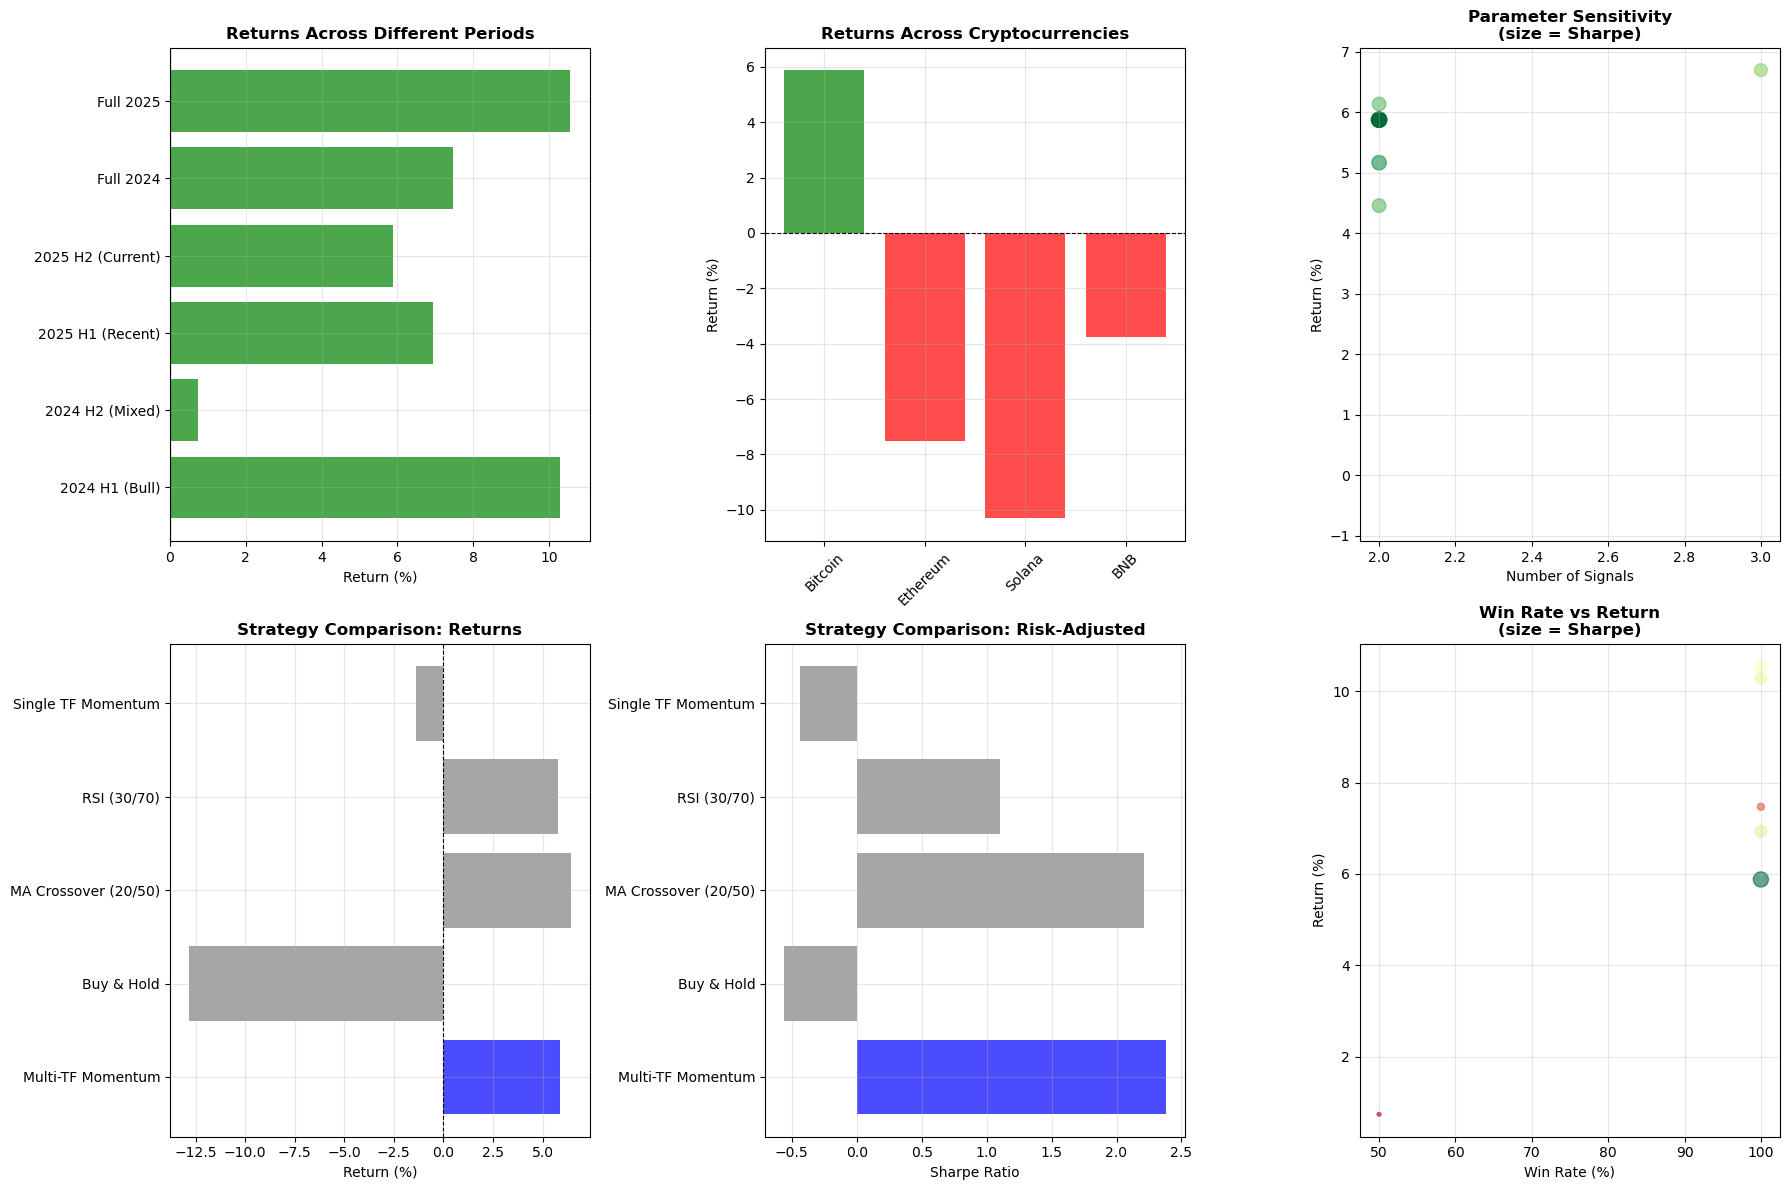


ALL ENHANCEMENTS COMPLETE!


In [6]:
# ============================================================================
# COMPREHENSIVE VISUALIZATION
# ============================================================================

print("\n" + "="*60)
print("GENERATING COMPREHENSIVE VISUALIZATIONS")
print("="*60)

fig = plt.figure(figsize=(18, 12))

# 1. Multi-Period Performance
if 'multi_period_results' in globals() and len(multi_period_results) > 0:
    ax1 = plt.subplot(2, 3, 1)
    valid_periods = multi_period_results[multi_period_results['Trades'] > 0]
    if len(valid_periods) > 0:
        colors = ['green' if x > 0 else 'red' for x in valid_periods['Strategy Return (%)']]
        ax1.barh(valid_periods['Period'], valid_periods['Strategy Return (%)'], color=colors, alpha=0.7)
        ax1.axvline(0, color='black', linestyle='--', linewidth=0.8)
        ax1.set_xlabel('Return (%)')
        ax1.set_title('Returns Across Different Periods', fontweight='bold')
        ax1.grid(True, alpha=0.3)

# 2. Multi-Crypto Performance
if 'multi_crypto_results' in globals() and len(multi_crypto_results) > 0:
    ax2 = plt.subplot(2, 3, 2)
    valid_cryptos = multi_crypto_results[multi_crypto_results['Trades'] > 0]
    if len(valid_cryptos) > 0:
        colors = ['green' if x > 0 else 'red' for x in valid_cryptos['Return (%)']]
        ax2.bar(valid_cryptos['Crypto'], valid_cryptos['Return (%)'], color=colors, alpha=0.7)
        ax2.axhline(0, color='black', linestyle='--', linewidth=0.8)
        ax2.set_ylabel('Return (%)')
        ax2.set_title('Returns Across Cryptocurrencies', fontweight='bold')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)

# 3. Parameter Sensitivity
if 'param_sensitivity_results' in globals() and len(param_sensitivity_results) > 0:
    ax3 = plt.subplot(2, 3, 3)
    ax3.scatter(param_sensitivity_results['Signals'], 
                param_sensitivity_results['Return (%)'],
                s=param_sensitivity_results['Sharpe']*50,
                alpha=0.6,
                c=param_sensitivity_results['Sharpe'],
                cmap='RdYlGn')
    ax3.set_xlabel('Number of Signals')
    ax3.set_ylabel('Return (%)')
    ax3.set_title('Parameter Sensitivity\n(size = Sharpe)', fontweight='bold')
    ax3.grid(True, alpha=0.3)

# 4. Strategy Comparison - Returns
if 'strategy_comparison_results' in globals() and len(strategy_comparison_results) > 0:
    ax4 = plt.subplot(2, 3, 4)
    colors = ['blue' if x == 'Multi-TF Momentum' else 'gray' 
              for x in strategy_comparison_results['Strategy']]
    ax4.barh(strategy_comparison_results['Strategy'], 
             strategy_comparison_results['Return (%)'],
             color=colors, alpha=0.7)
    ax4.axvline(0, color='black', linestyle='--', linewidth=0.8)
    ax4.set_xlabel('Return (%)')
    ax4.set_title('Strategy Comparison: Returns', fontweight='bold')
    ax4.grid(True, alpha=0.3)

# 5. Strategy Comparison - Sharpe
if 'strategy_comparison_results' in globals() and len(strategy_comparison_results) > 0:
    ax5 = plt.subplot(2, 3, 5)
    colors = ['blue' if x == 'Multi-TF Momentum' else 'gray' 
              for x in strategy_comparison_results['Strategy']]
    ax5.barh(strategy_comparison_results['Strategy'], 
             strategy_comparison_results['Sharpe'],
             color=colors, alpha=0.7)
    ax5.set_xlabel('Sharpe Ratio')
    ax5.set_title('Strategy Comparison: Risk-Adjusted', fontweight='bold')
    ax5.grid(True, alpha=0.3)

# 6. Win Rate vs Return (if multi-period)
if 'multi_period_results' in globals() and len(multi_period_results) > 0:
    ax6 = plt.subplot(2, 3, 6)
    valid_periods = multi_period_results[multi_period_results['Trades'] > 0]
    if len(valid_periods) > 0 and 'Win Rate (%)' in valid_periods.columns:
        ax6.scatter(valid_periods['Win Rate (%)'], 
                   valid_periods['Strategy Return (%)'],
                   s=valid_periods['Sharpe']*50,
                   alpha=0.6,
                   c=valid_periods['Sharpe'],
                   cmap='RdYlGn')
        ax6.set_xlabel('Win Rate (%)')
        ax6.set_ylabel('Return (%)')
        ax6.set_title('Win Rate vs Return\n(size = Sharpe)', fontweight='bold')
        ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('comprehensive_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Comprehensive visualization saved as 'comprehensive_analysis.png'")
plt.show()

print("\n" + "="*60)
print("ALL ENHANCEMENTS COMPLETE!")
print("="*60)